# Time Series Forecasting of Sales

# Introduction

This analysis is the project for "Time Series Forecasting". The purpose of the project is to forecast monthly sales data for a video game company, in order to help plan out the supply with demand for the company's video games. Throughout the analysis I will provide a forecast for the next 4 months of sales and report your findings.

# Data Preparation

In [4]:
# Import the relevant libraries 
import pandas as pd
import numpy as np
from sklearn import preprocessing
import matplotlib.pyplot as plt 
%matplotlib inline
plt.rc("font", size=14)
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
import seaborn as sns
sns.set()
sns.set(style="whitegrid", color_codes=True)

In [5]:
# Load the provided dataset
sales_data = pd.read_excel('monthly-sales.xlsx') 

In [7]:
sales_data.head(), sales_data.tail() # Glance at the dataset(1)

(     Month  Monthly Sales
 0  2008-01         154000
 1  2008-02          96000
 2  2008-03          73000
 3  2008-04          51000
 4  2008-05          53000,
       Month  Monthly Sales
 64  2013-05         231000
 65  2013-06         271000
 66  2013-07         329000
 67  2013-08         401000
 68  2013-09         553000)

In [10]:
sales_data.info() ## Glance at the dataset(2)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 69 entries, 0 to 68
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   Month          69 non-null     object
 1   Monthly Sales  69 non-null     int64 
dtypes: int64(1), object(1)
memory usage: 1.2+ KB


The initial analysis of the time series confirms the presence of four key characteristics: continuous time intervals, sequential measurements, equal spacing between observations, and at most one data point per time unit. The dataset consists of monthly sales data from January 2008 to September 2013, with the time interval set as the index for convenience. To build predictive models, the last four records (June 2013 to September 2013) were held out as a test sample, allowing for an evaluation of the model’s forecasting accuracy by comparing predicted values against actual sales.

In [13]:
sales_data = sales_data.set_index('Month')  # Set the time variable as an index
sales_data.index =  pd.date_range(start=sales_data.index[0] , periods=len(sales_data), freq='MS')

In [15]:
sales_data_train = sales_data.iloc[:-4, :] # Train set  
sales_data_test = sales_data.iloc[-4:, :] # Test set for validation

sales_data_train.index = pd.date_range(start=sales_data_train.index[0] , periods=len(sales_data_train), freq='MS')
sales_data_test.index = pd.date_range(start=sales_data_test.index[0] , periods=len(sales_data_test), freq='MS')

In [17]:
sales_data_train.shape, sales_data_test.shape

((65, 1), (4, 1))

In [19]:
sales_data_test['Monthly Sales']

2013-06-01    271000
2013-07-01    329000
2013-08-01    401000
2013-09-01    553000
Freq: MS, Name: Monthly Sales, dtype: int64

# Data Exploration

   - Visualize the Time Series
   - Determine Trend, Seasonal, and Error components


In [22]:
fig, ax = plt.subplots()
ax.plot(sales_data_train.index, sales_data_train['Monthly Sales'])
ax.set_ylabel('Monthly Sales Amount')
ax.set_xlabel('Year')
ax.set_title('Time Series Plots of Sales Amount', size=18)

Text(0.5, 1.0, 'Time Series Plots of Sales Amount')

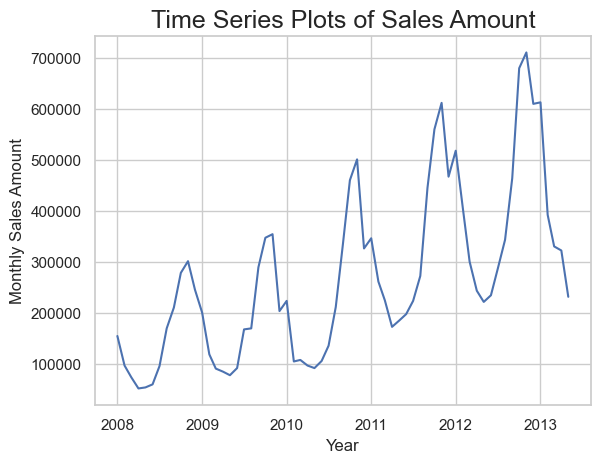

In [24]:
plt.show()

The Time Series Plot shows an overall increase in monthly sales. To select forecasting methods, the series is broken into systematic components—level, trend, and seasonality—and a non-systematic component, noise. These can combine additively or multiplicatively. The dataset’s components are visually analyzed in the decomposition plots in the next section.

# Determine Trend, Seasonal, and Error components

In [28]:
from statsmodels.tsa.seasonal import seasonal_decompose
res = seasonal_decompose(sales_data_train['Monthly Sales'], model='additive', period=12)

fig, (ax1,ax2,ax3,ax4) = plt.subplots(4,1, figsize=(12,10), sharex= True)
res.observed.plot(ax=ax1)
ax1.set_ylabel('Observed Data')
res.seasonal.plot(ax=ax2)
ax2.set_ylabel('Seasonal')
res.trend.plot(ax=ax3)
ax3.set_ylabel('Trend')
res.resid.plot(ax=ax4)
ax4.set_ylabel('Reminder')

plt.xlabel("Year")

Text(0.5, 0, 'Year')

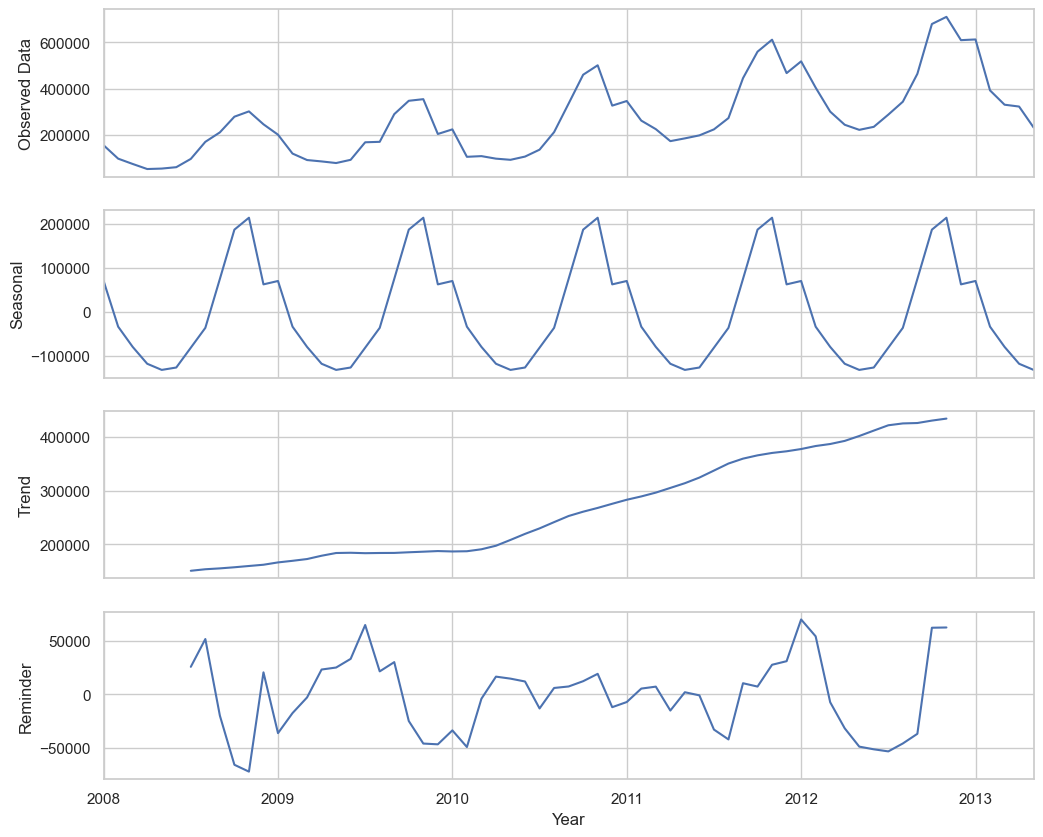

In [30]:
plt.show()

The decomposition plot breaks the time series into three components: trend, seasonality, and error. 

- The Trend line confirms an upward trend in sales.  
- The Seasonality subplot shows yearly sales spikes, slightly changing in magnitude. This suggests the need for seasonal differencing in ARIMA models and a multiplicative seasonal method for ETS models.  
- The Error plot shows fluctuating error magnitudes, indicating that ETS models should apply a multiplicative error approach.

# Data Analysis

 - Build the Forecasting Models
 - Predict the Holdout Sample
 - Forecast for the next 4 months of sales

# Build the Forecasting Models

In the previous section, I analyzed the decomposition graphs to inform forecasting models on the business problem. In this section, I determine the appropriate measurements to apply to the ETS model and the (Seasonal) ARIMA. Then I compare both models based on in-sample errors.

  - ETS Models
  - Seasonal ARIMA

# ETS Models

ETS stands for Error, Trend, and Seasonality, and are the three inputs in ETS models. From the decomposition plot, we can obtain the necessary information to define the terms for the ETS model.

   - The Trend line exhibits linear behavior so we will use an additive method.
   - The Seasonality changes in magnitude each year so a multiplicative method seems necessary.
   - The Error changes in magnitude as the series goes along so a multiplicative method will be used.
   - This leaves us with an ETS(M, A, M) model.


In [37]:
# Import the relevant libraries 
from statsmodels.tsa.exponential_smoothing.ets import ETSModel 

In [39]:
sales_data_train = pd.Series(sales_data_train['Monthly Sales']).astype('float64')
ets_model = ETSModel(sales_data_train, error='mul', trend='add', seasonal = 'mul', 
                     damped_trend=True, seasonal_periods=12, initial_level=sales_data_train.values.mean(), freq='MS')
ets_fitted = ets_model.fit()

In [41]:
print(ets_fitted.summary())

                                 ETS Results                                  
Dep. Variable:          Monthly Sales   No. Observations:                   65
Model:                      ETS(MAdM)   Log Likelihood                -758.979
Date:                Thu, 03 Apr 2025   AIC                           1555.958
Time:                        16:37:07   BIC                           1597.272
Sample:                    01-01-2008   HQIC                          1572.259
                         - 05-01-2013   Scale                            0.017
Covariance Type:               approx                                         
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
smoothing_level         0.9999        nan        nan        nan         nan         nan
smoothing_trend      9.999e-05      0.047      0.002      0.998      -0.091       0.091
smoothing_season

In [43]:
plt.figure(figsize=(10,8))
sales_data_train.plot(label='Original data')
ets_fitted.fittedvalues.plot(label='Statsmodels fit - ETS Model')
plt.title('Visualisation of Time Series Data and fitted data by ETS Model' , fontsize=16)
plt.ylabel("Monthly Sales Amount");
plt.xlabel("Year")
plt.legend();

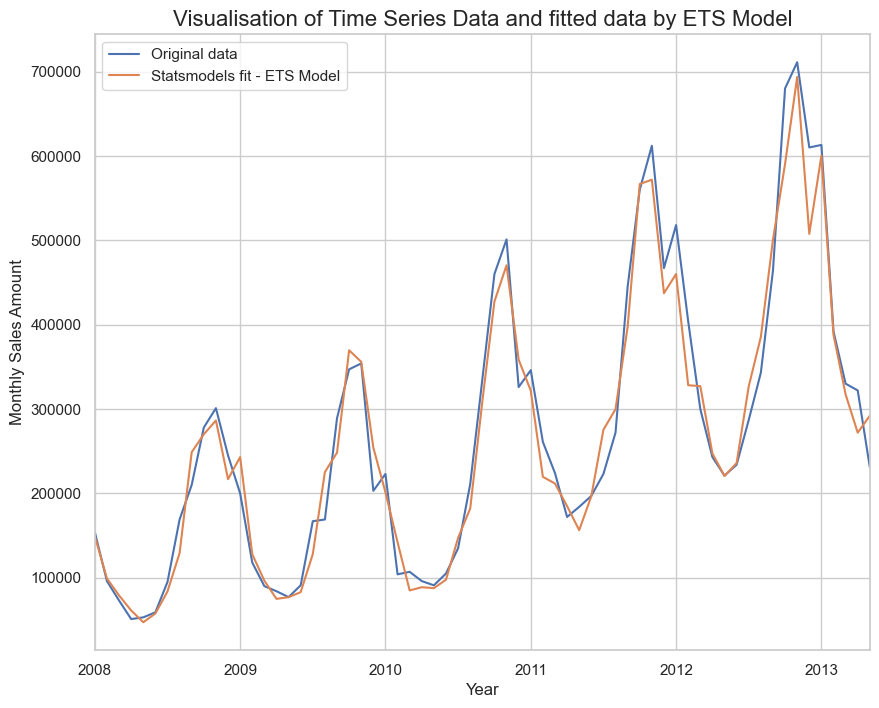

In [45]:
plt.show()

In [47]:
pred_ets= ets_fitted.fittedvalues # Store the predicted values based on ETS model as "pred_ets"

# Evaluating In-Sample Accuracy (ETS Models)

    Now, I describe the in-sample errors based on ETS models. The in-sample error measures give us a look at how well our model is able to predict future values. Among the various Error Terms, I chose:

       - RMSE (Rooted Mean Squared Error)
       - MAE (Mean Absolute Error)
       - MAPE (Mean Absolute Percentage Error)
       - MASE (Mean Absolute Scaled Error)

    For some error terms, I directly use the existing functions from the scikit-learn library. Otherwise, I calculate the error terms for a list of predictions. 

In [50]:
expected_ets = sales_data_train.values
predicted_ets = pred_ets.values

In [52]:
from sklearn.metrics import mean_squared_error
from math import sqrt
from sklearn.metrics import mean_absolute_error

def mean_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean((y_true - y_pred) / y_true * 100)

def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def running_diff(arr, N):
    return np.array([arr[i] - arr[i-N] for i in range(N, len(arr))])

def mean_absolute_scaled_error(training_series, testing_series, prediction_series):
    errors_mean = np.abs(testing_series - prediction_series ).mean()
    d = np.abs(running_diff(training_series, 12) ).mean()
    return errors_mean/d

mse_ets  = mean_squared_error(expected_ets, predicted_ets)
rmse_ets = sqrt(mse_ets)
mae_ets  = mean_absolute_error(expected_ets, predicted_ets)
mpe_ets  = mean_percentage_error(expected_ets, predicted_ets)
mape_ets = mean_absolute_percentage_error(expected_ets, predicted_ets)
mase_ets = mean_absolute_scaled_error(expected_ets, expected_ets, predicted_ets)

print('In-Sample Error Measures of ETS Models:')
print('')
print('- RMSE: %.2f' % rmse_ets)
print('- MAE : %.2f' % mae_ets)
print('- MPE : %.2f' % mpe_ets)
print('- MAPE: %.2f' % mape_ets)
print('- MASE: %.2f' % mase_ets)

In-Sample Error Measures of ETS Models:

- RMSE: 33983.10
- MAE : 25891.56
- MPE : 0.63
- MAPE: 10.57
- MASE: 0.38


# Error metrics help evaluate forecasting accuracy.  

- **Scale-dependent errors:** MAE (Mean Absolute Error) and RMSE (Root Mean Squared Error) are common measures. MAE minimizes median errors, while RMSE minimizes mean errors and is more sensitive to large deviations.  
- **Percentage errors:** MAPE (Mean Absolute Percentage Error) is unit-free, making it useful for comparing forecasts across datasets.  
- **Scaled errors:** Proposed by Hyndman & Koehler (2006), MASE (Mean Absolute Scaled Error) compares performance against a naïve forecast. A value below 1 indicates a better-than-naïve forecast.  

In this analysis, RMSE is around 34,000 units, and MASE is 0.38, indicating strong model accuracy.

# Seasonal ARIMA

In Time Series Analysis, we should start the analysis with a "stationary" data. make the data stationary. As the decomposition plots exhibit, the provided dataset seems to have seasonality and linear Trend. Augmented Dickey Fuller test reminds us the fact that the given data is not stationary.


In [56]:
# Augmented Dickey Fuller test
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from numpy import log
result = adfuller(sales_data_train.dropna())
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

ADF Statistic: 1.613050
p-value: 0.997896


By differencing data points, I make the time series stationary.

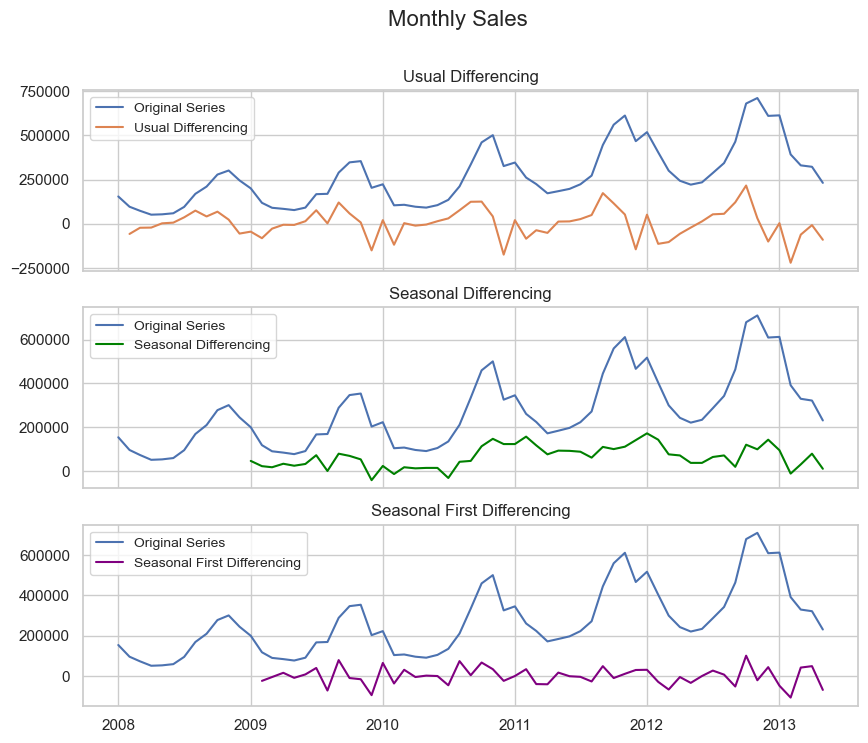

In [59]:
# Plot
fig, axes = plt.subplots(3, 1, figsize=(10,8), dpi=100, sharex=True)

# Usual Differencing
axes[0].plot(sales_data_train, label='Original Series')
axes[0].plot(sales_data_train.diff(1), label='Usual Differencing')
axes[0].set_title('Usual Differencing')
axes[0].legend(loc='upper left', fontsize=10)
sales_data_diff = sales_data_train.diff(1)

# Seasinal Dei
axes[1].plot(sales_data_train, label='Original Series')
axes[1].plot(sales_data_train.diff(12), label='Seasonal Differencing', color='green')
axes[1].set_title('Seasonal Differencing')
axes[1].legend(loc='upper left', fontsize=10)

# Seasinal first differencing 
axes[2].plot(sales_data_train, label='Original Series')
axes[2].plot(sales_data_diff.diff(12), label='Seasonal First Differencing', color='purple')
axes[2].set_title('Seasonal First Differencing')
axes[2].legend(loc='upper left', fontsize=10)
plt.suptitle('Monthly Sales', fontsize=16)
plt.show()

In [61]:
# Augmented Dickey Fuller test for Seasonal First Differencing Data 
seasonal_first_differencing = sales_data_diff.diff(12)
result_seasonal_first_diff = adfuller(seasonal_first_differencing.dropna())
print('ADF Statistic for Seasonal First Differencing: %.4f' % result_seasonal_first_diff[0])
print('p-value for Seasonal First Differencing: %.4f' % result_seasonal_first_diff[1])

ADF Statistic for Seasonal First Differencing: -9.4464
p-value for Seasonal First Differencing: 0.0000


As you can see from the third plot, the original time series data is changed a stationary data after seasonal first differencing. This fact can be also confirmed by the p-value of Augmented Dickey Fuller test. Taking the seasonal first difference has now made our data stationary. Next, I find the optimal parameters based on the Time Series ACF and PACF graphs. 

### Time Series ACF and PACF

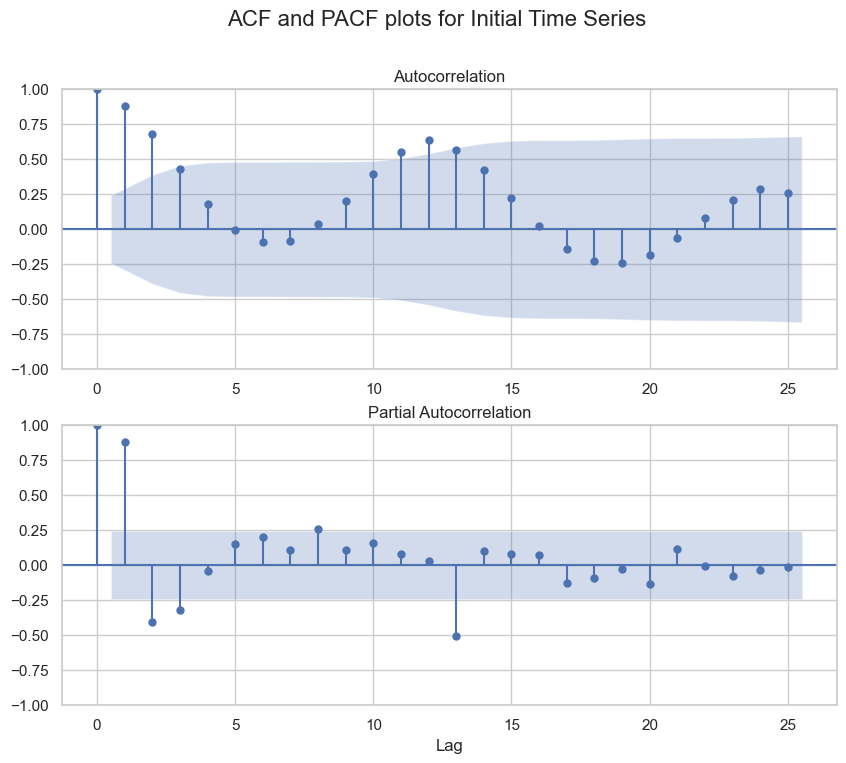

In [65]:
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf

fig = plt.figure(figsize=(10,8))
ax1 = fig.add_subplot(211)
fig=plot_acf(sales_data_train,  lags=25, ax=ax1)

ax2 = fig.add_subplot(212)
fig=plot_pacf(sales_data_train, lags=25,  ax=ax2)

plt.xlabel('Lag')
plt.suptitle('ACF and PACF plots for Initial Time Series', fontsize=16)
plt.show()

The ACF presents slowly decaying serial correlations towards 0 with increases at the seasonal lags. Since serial correlation is high I will need to seasonally difference the series.

### Seasonal Difference ACF and PACF

C:\Users\HP\AppData\Local\Temp\ipykernel_20132\2908361813.py:14: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return np.array([arr[i] - arr[i-N] for i in range(N, len(arr))])


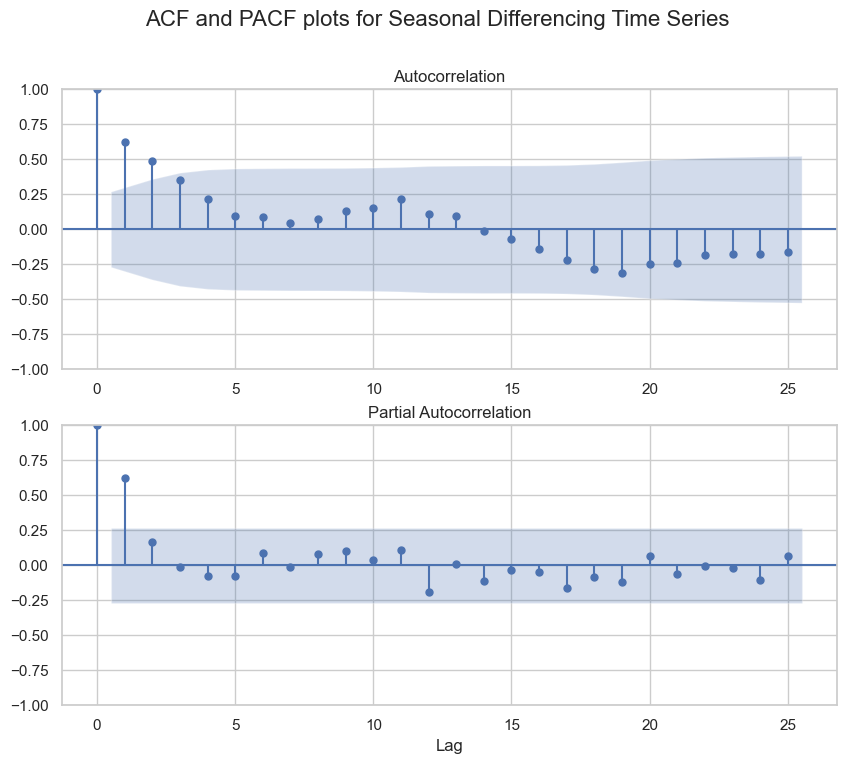

In [69]:
seasonal_diff = running_diff(sales_data_train, 12) 

fig = plt.figure(figsize=(10,8))
ax1 = fig.add_subplot(211)
fig=plot_acf(seasonal_diff, lags=25,  ax=ax1)

ax2 = fig.add_subplot(212)
fig=plot_pacf(seasonal_diff, lags=25,  ax=ax2)

plt.xlabel('Lag')
plt.suptitle('ACF and PACF plots for Seasonal Differencing Time Series', fontsize=16)
plt.show()

The seasonal difference presents similar ACF and PACF patterns as the initial plots, without differencing, only slightly less correlated. In order to remove correlation we will need to difference further.

### Seasonal First Difference ACF and PACF

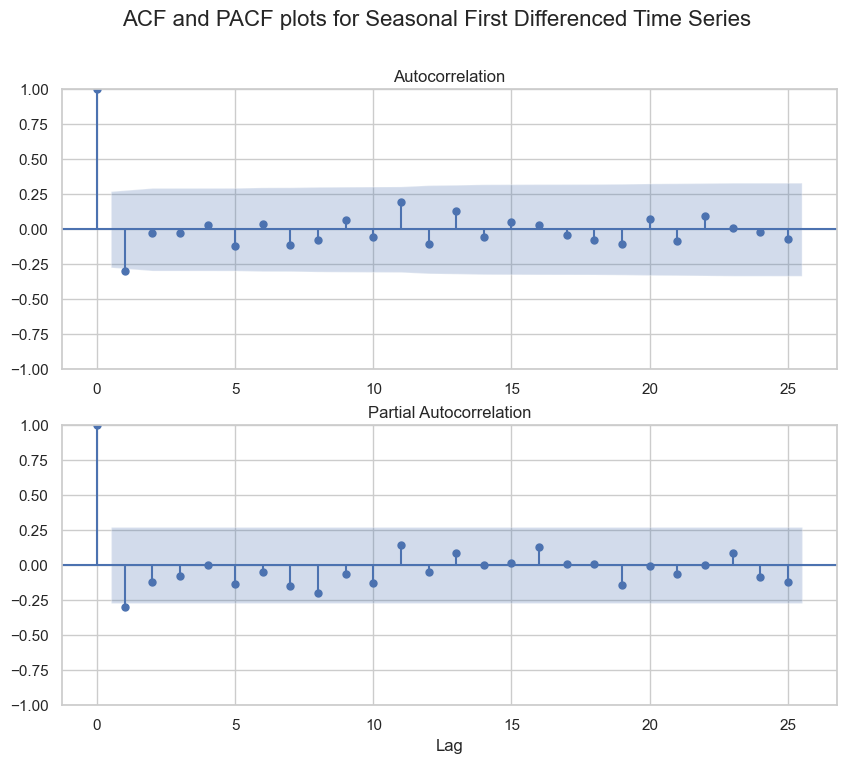

In [73]:
seasonal_diff_1 = running_diff(seasonal_diff, 1) 

fig = plt.figure(figsize=(10,8))
ax1 = fig.add_subplot(211)
fig=plot_acf(seasonal_diff_1, lags=25,  ax=ax1)

ax2 = fig.add_subplot(212)
fig=plot_pacf(seasonal_diff_1, lags=25,  ax=ax2)

plt.xlabel('Lag')
plt.suptitle('ACF and PACF plots for Seasonal First Differenced Time Series', fontsize=16)
plt.show()

After applying seasonal first differencing, most significant lags in the ACF and PACF plots are removed, eliminating the need for further differencing. The remaining correlation suggests using autoregressive (AR) and moving average (MA) terms, leading to differencing terms **d(1) and D(1).**  

- **ACF Analysis:** A strong negative correlation at lag-1 indicates an MA(1) process.  
- **PACF Analysis:** Confirms the MA(1) structure.  
- **Seasonal Lags:** No significant correlation at seasonal lags (12, 24, etc.), so no seasonal AR or MA terms are needed.  

Thus, the optimal ARIMA model is **ARIMA(0,1,1)(0,1,0)[12],** meaning a non-seasonal MA(1) with first-order differencing and seasonal differencing but no seasonal AR/MA terms. The ACF and PACF plots confirm no need for additional terms.

# Define the Seasonal ARIMA model

In [78]:
# Define model
model_sarima = sm.tsa.statespace.SARIMAX(endog = sales_data_train, 
                                         order=(0, 1, 1), seasonal_order=(0,1,0,12), 
                                         trend = 't', freq = 'MS',
                                         seasonal_periods =12, 
                                         enforce_stationarity=False, 
                                         enforce_invertibility=False)
# FIt Model
sarima_fitted = model_sarima.fit(dynamic=False)
print(sarima_fitted.summary())

                                      SARIMAX Results                                      
Dep. Variable:                       Monthly Sales   No. Observations:                   65
Model:             SARIMAX(0, 1, 1)x(0, 1, [], 12)   Log Likelihood                -602.879
Date:                             Thu, 03 Apr 2025   AIC                           1211.757
Time:                                     16:46:05   BIC                           1217.493
Sample:                                 01-01-2008   HQIC                          1213.942
                                      - 05-01-2013                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
drift        -22.1133     83.683     -0.264      0.792    -186.128     141.902
ma.L1         -0.3884      

C:\Users\HP\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['seasonal_periods']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
C:\Users\HP\anaconda3\Lib\site-packages\statsmodels\base\optimizer.py:19: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method lbfgs is: m, pgtol, factr, maxfun, epsilon, approx_grad, bounds, loglike_and_score, iprint. The list of unsupported keyword arguments passed include: dynamic. After release 0.14, this will raise.
  warnings.warn(


# Plot Residual Errors

Plotting residuals make us ensure there are no patterns. In other words, we can check for constant mean and variance of residuals. 

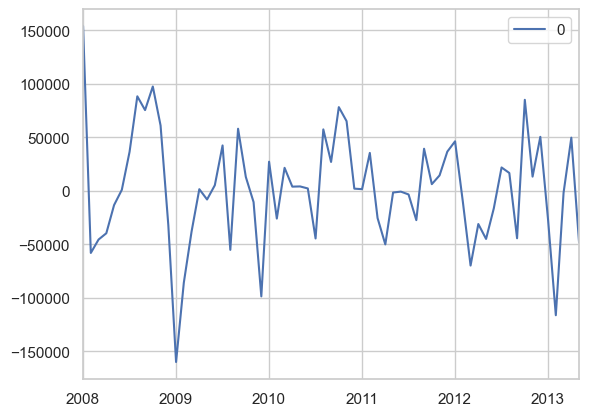

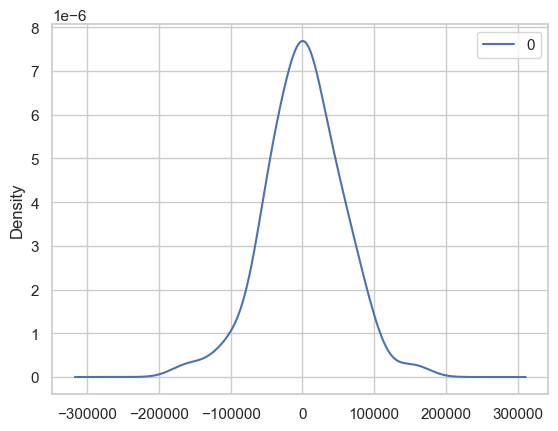

                   0
count      65.000000
mean     1666.873429
std     53192.284293
min   -159843.209333
25%    -30967.036579
50%      1602.439457
75%     36504.352110
max    154000.000000


In [81]:
residuals = pd.DataFrame(sarima_fitted.resid)
residuals.plot()
plt.show()
residuals.plot(kind='kde')
plt.show()
print(residuals.describe())

In [83]:
# Compare the Original Time Series and Fitted values 
sales_data_train.plot(label='Original data',figsize=(8,6))
sarima_fitted.fittedvalues.plot(label='Seasonal ARIMA - Statsmodels fit')
plt.ylabel("Monthly Sales Amount");
plt.xlabel("Year")
plt.title('Actual vs. Fitted Values', fontsize= 16)
plt.legend();

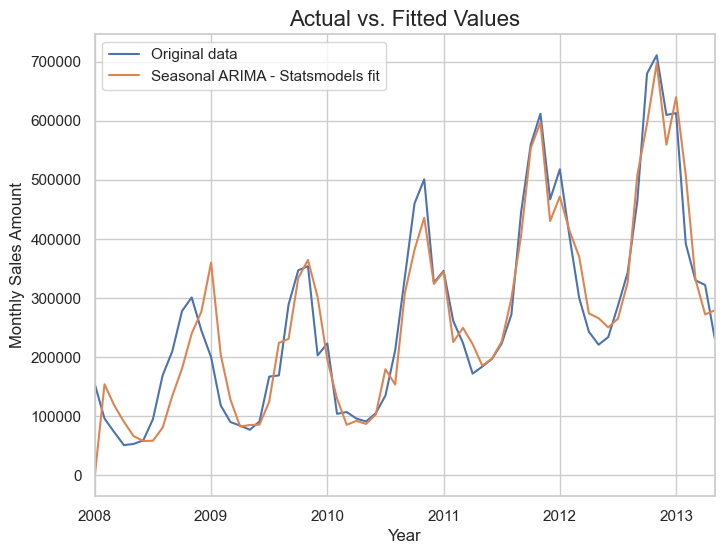

In [85]:
plt.show()

### Evaluating In-Sample Accuracy (Seasonal ARIMA)

In [88]:
predicted_sarima = sarima_fitted.predict().values
expected_sarima = sales_data_train.values

mse_sarima  = mean_squared_error(expected_sarima, predicted_sarima)
rmse_sarima = sqrt(mse_sarima)
mae_sarima  = mean_absolute_error(expected_sarima, predicted_sarima)
mpe_sarima  = mean_percentage_error(expected_sarima, predicted_sarima)
mape_sarima = mean_absolute_percentage_error(expected_sarima, predicted_sarima)
mase_sarima = mean_absolute_scaled_error(expected_sarima, expected_sarima, predicted_sarima)

print('In-Sample Error Measures of Seasonal ARIMA Models:')
print(' ')
print('- RMSE : %f' % rmse_sarima)
print('- MAE  : %f' % mae_sarima)
print('- MPE  : %f' % mpe_sarima)
print('- MAPE : %f' % mape_sarima)
print('- MASE : %f' % mase_sarima)

In-Sample Error Measures of Seasonal ARIMA Models:
 
- RMSE : 52807.840806
- MAE  : 39576.055779
- MPE  : -3.478530
- MAPE : 20.196629
- MASE : 0.577355


I analyzed the training part of the time series using **ETS Models** and **Seasonal ARIMA** and compared their performance using **in-sample error measures** like **RMSE, MAPE, and MASE**. The ETS model has a lower RMSE, indicating a **narrower standard deviation**. Although the MASE value of the ETS model is lower than that of Seasonal ARIMA, both fall below the **1.00 threshold**, confirming model accuracy.  

Next, I evaluate the **prediction performance** of both models using **holdout samples** to assess how well they generalize to unseen data.

# Predict the Holdout Sample

In [92]:
# ETS Model for Validation 
sales_data = pd.Series(sales_data['Monthly Sales']).astype('float64')
ets_model_holdout = ETSModel(sales_data, error='mul', trend='add', seasonal = 'mul', 
                             damped_trend=True, seasonal_periods=12, 
                             initial_level=sales_data_train.values.mean(), freq='MS')
ets_fitted_holdout = ets_model_holdout.fit()

In [94]:
# Predicted values for holdout samples (test samples) - ETS model 
ets_fitted_holdout.predict()[-4:]

2013-06-01    250580.934257
2013-07-01    371513.382923
2013-08-01    435702.782764
2013-09-01    580155.740230
Freq: MS, dtype: float64

In [96]:
# Seasonal ARIMA Model for Validation
model_sarima_holdout = sm.tsa.statespace.SARIMAX(endog = sales_data, 
                                                 order=(0, 1, 1), seasonal_order=(0,1,0,12), 
                                                 trend = 't', freq = 'MS',
                                                 seasonal_periods =12, 
                                                 enforce_stationarity=False, 
                                                 enforce_invertibility=False)
sarima_fitted_holdout = model_sarima_holdout.fit(dynamic=False)

C:\Users\HP\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['seasonal_periods']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
C:\Users\HP\anaconda3\Lib\site-packages\statsmodels\base\optimizer.py:19: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method lbfgs is: m, pgtol, factr, maxfun, epsilon, approx_grad, bounds, loglike_and_score, iprint. The list of unsupported keyword arguments passed include: dynamic. After release 0.14, this will raise.
  warnings.warn(


In [98]:
# Predicted values for holdout samples (test samples) - Seasonal ARIMA model
sarima_fitted_holdout.predict()[-4:]

2013-06-01    265077.673497
2013-07-01    322917.680758
2013-08-01    383874.673686
2013-09-01    516710.170389
Freq: MS, Name: predicted_mean, dtype: float64

In [100]:
holdout_results = pd.DataFrame({'actual': sales_data_test['Monthly Sales'], 
                                 'predicted_ETS': ets_fitted_holdout.predict()[-4:].values, 
                                 'predicted_ARIMA': sarima_fitted_holdout.predict()[-4:].values }, 
                               index = sales_data_test.index) 
holdout_results

,actual,predicted_ETS,predicted_ARIMA
2013-06-01,271000,250580.934257,265077.673497
2013-07-01,329000,371513.382923,322917.680758
2013-08-01,401000,435702.782764,383874.673686
2013-09-01,553000,580155.740230,516710.170389


### Holdout Sample Prediction Error Comparison

In [103]:
sales_data_train

2008-01-01    154000.0
2008-02-01     96000.0
2008-03-01     73000.0
2008-04-01     51000.0
2008-05-01     53000.0
                ...   
2013-01-01    613000.0
2013-02-01    392000.0
2013-03-01    330000.0
2013-04-01    322000.0
2013-05-01    231000.0
Freq: MS, Name: Monthly Sales, Length: 65, dtype: float64

In [105]:
# Holdout-Sample Errors Comparison
# ETS Model 
mse_ets_hos  = mean_squared_error(sales_data_test['Monthly Sales'], holdout_results['predicted_ETS'])
rmse_ets_hos = sqrt(mse_ets_hos)
mae_ets_hos  = mean_absolute_error(sales_data_test['Monthly Sales'], holdout_results['predicted_ETS'])
mpe_ets_hos  = mean_percentage_error(sales_data_test['Monthly Sales'], holdout_results['predicted_ETS'])
mape_ets_hos = mean_absolute_percentage_error(sales_data_test['Monthly Sales'], holdout_results['predicted_ETS'])
mase_ets_hos = mean_absolute_scaled_error(sales_data_train.values, sales_data_test['Monthly Sales'], holdout_results['predicted_ETS'])

print('Holdout-Sample Error Measures of ETS Models:')
print(' ')
print('- RMSE : %.3f' % rmse_ets_hos)
print('- MAE  : %.3f' % mae_ets_hos)
print('- MPE  : %.3f' % mpe_ets_hos)
print('- MAPE : %.3f' % mape_ets_hos)
print('- MASE : %.3f' % mase_ets_hos)
print(' ')
# (Seasonal) ARIMA Model
mse_sarima_hos  = mean_squared_error(sales_data_test['Monthly Sales'], holdout_results['predicted_ARIMA'])
rmse_sarima_hos = sqrt(mse_sarima_hos)
mae_sarima_hos  = mean_absolute_error(sales_data_test['Monthly Sales'],  holdout_results['predicted_ARIMA'])
mpe_sarima_hos  = mean_percentage_error(sales_data_test['Monthly Sales'],  holdout_results['predicted_ARIMA'])
mape_sarima_hos = mean_absolute_percentage_error(sales_data_test['Monthly Sales'],  holdout_results['predicted_ARIMA'])
mase_sarima_hos = mean_absolute_scaled_error(sales_data_train.values, sales_data_test['Monthly Sales'],  holdout_results['predicted_ARIMA'])
print(' ')
print('Holdout-Sample Error Measures of Seasonal ARIMA Models:')
print(' ')
print('- RMSE : %.3f' % rmse_sarima_hos)
print('- MAE  : %.3f' % mae_sarima_hos)
print('- MPE  : %.3f' % mpe_sarima_hos)
print('- MAPE : %.3f' % mape_sarima_hos)
print('- MASE : %.3f' % mase_sarima_hos)

Holdout-Sample Error Measures of ETS Models:
 
- RMSE : 32272.447
- MAE  : 31197.743
- MPE  : -4.738
- MAPE : 8.505
- MASE : 0.455
 
 
Holdout-Sample Error Measures of Seasonal ARIMA Models:
 
- RMSE : 20507.908
- MAE  : 16354.950
- MPE  : 3.717
- MAPE : 3.717
- MASE : 0.239


When looking at the model's ability to predict the holdout sample, we can recognize that the Seasonal ARIMA model shows better predictive performance in all metrics. 

# Forecast for the next 4 months of Sales

Previously, I concluded that the Seasonal ARIMA model shows better performance in terms of prediction. Now, I forecast for the next four-month sales using all the time series data based on the same Seasonal ARIMA model. First, I diagnose the stationarity of the whole time series data again. Then the forecast results are calculated using 95% and 80% confidence intervals.


In [109]:
# Seasonal ARIMA Model for Forecasting 
model_sarima_final = sm.tsa.statespace.SARIMAX(sales_data, order=(0, 1, 1), 
                                             seasonal_order=(0,1,0,12), trend = 't', 
                                             seasonal_periods =12, 
                                             enforce_stationarity=False, enforce_invertibility=False)
# FIt Model
sarima_fitted_final = model_sarima_final.fit(dynamic=False)

C:\Users\HP\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['seasonal_periods']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
C:\Users\HP\anaconda3\Lib\site-packages\statsmodels\base\optimizer.py:19: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method lbfgs is: m, pgtol, factr, maxfun, epsilon, approx_grad, bounds, loglike_and_score, iprint. The list of unsupported keyword arguments passed include: dynamic. After release 0.14, this will raise.
  warnings.warn(


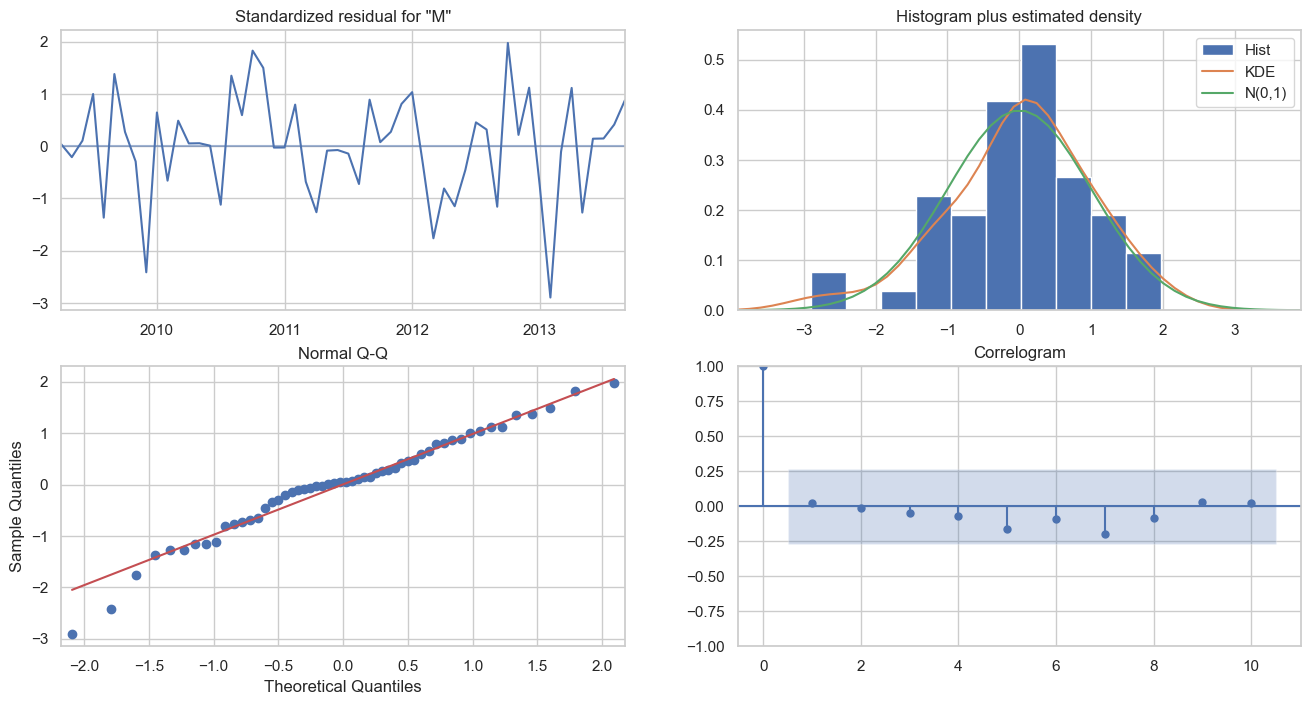

In [111]:
sarima_fitted_final.plot_diagnostics(figsize=(16, 8))
plt.show()

In [113]:
# Forecast the nest 4 periods of Sales Amount
fcast = sarima_fitted_final.get_forecast(4)
forecast_results = pd.DataFrame({'forecast_mean': fcast.predicted_mean, 
                                 'forecast_high_95': fcast.conf_int(alpha= 0.05).iloc[:,1], 
                                 'forecast_high_80': fcast.conf_int(alpha= 0.20).iloc[:,1], 
                                 'forecast_low_80': fcast.conf_int(alpha= 0.20).iloc[:,0], 
                                 'forecast_low_95': fcast.conf_int(alpha= 0.05).iloc[:,0], 
                                }) 
forecast_results.index = pd.date_range(start=forecast_results.index[0] , periods=len(forecast_results), freq='MS')
forecast_results

C:\Users\HP\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['seasonal_periods']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


,forecast_mean,forecast_high_95,forecast_high_80,forecast_low_80,forecast_low_95
2013-10-01,756469.982819,837662.052660,809558.623751,703381.341887,675277.912978
2013-11-01,788700.836849,884287.127270,851201.352725,726200.320972,693114.546428
2013-12-01,688949.274507,797029.455983,759619.106640,618279.442374,580869.093032
2014-01-01,693215.295795,812487.724877,771203.345281,615227.246309,573942.866713


In [115]:
# Visualize the forecast results 
sales_data.plot(figsize=(18,10))
sarima_fitted_final.fittedvalues.plot(label = 'fitted value')
forecast_results.forecast_mean.plot()
upper_series_80 = forecast_results.forecast_high_80
lower_series_80 = forecast_results.forecast_low_80
upper_series_95 = forecast_results.forecast_high_95
lower_series_95 = forecast_results.forecast_low_95

plt.fill_between(upper_series_80.index, 
                 lower_series_80, 
                 upper_series_80, 
                 color='k', alpha=.15)

plt.fill_between(lower_series_95.index, 
                 lower_series_95, 
                 upper_series_95, 
                 color= None, linestyle ='--', alpha=.15)
plt.legend(loc = 'upper left', fontsize =15)
plt.xlabel('Year')
plt.ylabel('Monthly Sales in USD')
plt.title('Actual and Forecast Values', fontsize = 18)

Text(0.5, 1.0, 'Actual and Forecast Values')

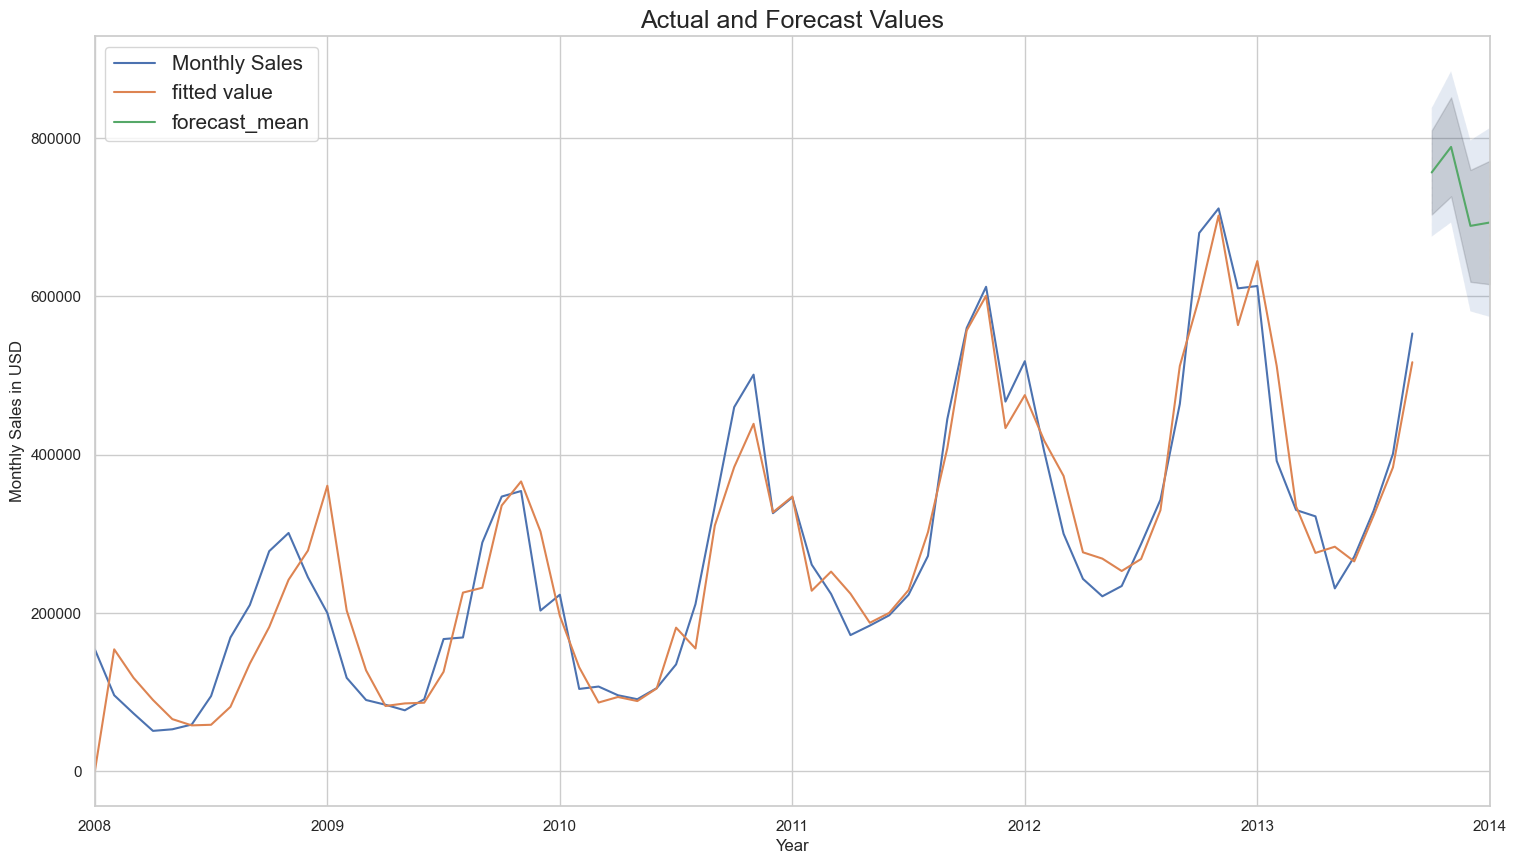

In [117]:
plt.show()

# Conclusion

This analysis is mainly about forecasting for upcoming sales in a video game company. Firstly, I investigate and prepare the time series data. The provided data was appropriate to use time series models and I held out the last 4 periods of data points for validation. Then, I determined Trend, Seasonal and Error components in the data based on decomposition plots. After that, I analyse the data by applying the ARIMA and ETS models and describe the errors for both models. I compared the in-sample error measurements to both models and compare error measurements for the holdout sample in the forecast. Finally,I choose the best fitting model and forecast the next four periods. 